In [338]:
### Plummer's Sphere Equilibrium - Initial Conditions code for 'treecode' ### 

In [339]:
###################################################################################################################

In [340]:
## Section 1 - Creation of the initial condition file ## 

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Definition of the parameters of the system (in internal units)
Nparticles = 1000
Ndimensions = 3
time = 0   # initial time simulation
r_scale = 1 # scale radius of the Plummer's sphere 
M = 10    # total mass of the system
m = M/Nparticles # mass of each particle (equal mass particles)

## distribution function (not normalized)
def dist_func(q):
    return (1-q**2)**(7/2)*q**2

q_max = (2)**(1/2)/3  # abscissa where the distribution 'dist_func' has a maximum
f_max = dist_func(q_max) 

## Positions setting function
def positions(b):  
    # position of the particle in spherical coordinates
    k = np.random.random() # generation of a random number uniformly distributed in [0,1) 
    R = b*k**(1/3)/(1-k**(2/3))**(1/2)
    k = np.random.random()
    t = math.acos(1-(2*k))
    k = np.random.random()
    f = 2*(math.pi)*k 
    # position of the particle in cartesian coordinates
    x = R*(math.sin(t))*(math.cos(f))
    y = R*(math.sin(t))*(math.sin(f))
    z = R*(math.cos(t))
    return x,y,z,R,t,f

## Velocity setting function
def velocities(a,b):      
    rel_pot = M/(a**2+b**2)**(1/2) # relative potential of the particle
    v_max = (2*rel_pot)**(1/2)
    leave = 'False' # used to exit the 'while' cycle
    while leave=='False':
        q = np.random.random() 
        q1 = np.random.random()*f_max   
        if q1<=dist_func(q):
            vmod = q*v_max # modulo of the velocity
            # spherical distribution in the velocities: theta and phi distributed in such a way
            k = np.random.random()
            t = math.acos(1-(2*k))
            k = np.random.random()
            f = 2*(math.pi)*k 
            # velocity of the particle in cartesian coordinates
            vx = vmod*(math.sin(t))*(math.cos(f))
            vy = vmod*(math.sin(t))*(math.sin(f))
            vz = vmod*(math.cos(t))
            leave = 'True'
    return vx,vy,vz,q

## Creation and filling of the position and velocity arrays
x = np.empty(Nparticles)
y = np.empty(Nparticles)
z = np.empty(Nparticles)
vx = np.empty(Nparticles)
vy = np.empty(Nparticles)
vz = np.empty(Nparticles)

## Radius, theta, phi and q arrays are used in the next section to check if the initial conditions are correct
radius = np.empty(Nparticles)  
theta = np.empty(Nparticles)
phi = np.empty(Nparticles)
q = np.empty(Nparticles) 

for i in range(Nparticles):
    x[i],y[i],z[i],radius[i],theta[i],phi[i] = positions(r_scale)
    vx[i],vy[i],vz[i],q[i] = velocities(radius[i],r_scale)

In [2]:
## Saving the initial conditions in 'initial_conditions_file.txt' that then will be runned by the c++ code
with open('initial_conditions_file.txt','w') as file:
    file.write("{}\n{}\n{}\n".format(Nparticles,Ndimensions,time))
    for i in range(Nparticles):
        file.write("{}\n".format(m))
    for i in range(Nparticles):
        file.write("{:25.15e}{:25.15e}{:25.15e}\n".format(x[i],y[i],z[i]))
    for i in range(Nparticles):
        file.write("{:25.15e}{:25.15e}{:25.15e}\n".format(vx[i],vy[i],vz[i]))  
## Saving some system's parameters used during the analysis section
with open('system_properties.txt','w') as file:
    file.write("{}\n{}\n{}\n".format(Nparticles,M,r_scale))

In [343]:
###################################################################################################################

In [344]:
## Section 2 - Check of the Initial Conditions ##

In [345]:
# For more details about the statistics and what is done here, see the similar section in the Analysis Code.
# Before evolving the system, it's recommended to check the initial conditions: this can done directly in the 
# analysis code (choosing the variable 'snapshot_to_check = 0'); however, for computational costs, we recommend 
# to do it here (indeed here we have already the R, theta, phi and q arrays; in the analysis code they have to be
# recomputed)

In [346]:
from scipy.stats import chisquare

In [347]:
## Radius Distribution

In [348]:
## pdf and cdf of the radial positions 
def pdf_r(r,b):
    return (3/b**3)*(r**2)*(1+(r/b)**2)**(-5/2) 
def cdf_r(b,r):
    return b**(-3)*r**3/(1+(r/b)**2)**(3/2)

In [349]:
# Chisquare Section #
empirical,edges = np.histogram(radius,bins='auto')
counts = np.copy(empirical) # used in the histogram section
theorical = []
for i_bin in range(len(empirical)):
    if empirical[i_bin]>9:
        prob = cdf_r(r_scale,edges[i_bin+1]) - cdf_r(r_scale,edges[i_bin])
        theorical.append(prob*Nparticles)        
empirical = empirical[empirical>9] 

sta, pvalue = chisquare(empirical,theorical)
if pvalue>=0.05: print('pvalue: {}, test superato'.format(pvalue))
else: print('pvalue: {}, test non superato'.format(pvalue))

pvalue: 0.040273054110285374, test non superato


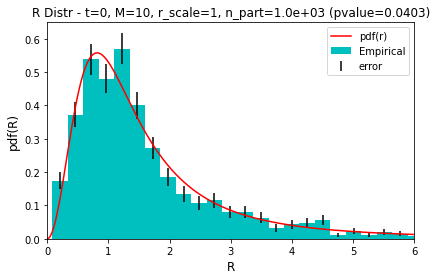

In [350]:
# Histogram Section #

# Generation of the normalized histogram and of the error bars
area = sum(np.diff(edges)*counts)
error = np.sqrt(counts) # Poissonian errors
bincenters = 0.5*(edges[1:]+edges[:-1])

normalized_counts_r, bin_edges_r, hist_r = plt.hist(radius,bins='auto',range=None,density=True,color='c',label='Empirical')
                                    # the bins selection is made through the 'auto' mode: maximum number of
                                    # bins between the 'Freedman–Diaconis rule' or the 'Sturge’s Rule' computation

error = np.divide(error, area) # the error bar must be rescaled since we normalized the histogram 
plt.errorbar(bincenters,normalized_counts_r,yerr=error,fmt='none',label='error',color='k')

## generation of the arrays containing some pdf's points
left_range = 0
right_range = 6
radius_pdf = np.empty(1000)
ascissa = np.linspace(left_range,right_range,1000)     
radius_pdf = pdf_r(ascissa,r_scale) 

plt.plot(ascissa,radius_pdf,color='r',label='pdf(r)')
plt.xlim(left_range,right_range)
plt.xlabel('R',fontsize=12)
plt.ylabel('pdf(R)',fontsize=12)
plt.title('R Distr - t=0, M={}, r_scale={}, n_part={:3.1e} (pvalue={:3.3})'.format(M,r_scale,Nparticles,pvalue))
plt.legend()
plt.tight_layout()
plt.savefig('R_histo_1000.jpg') 
# N.B. if you change the scale radius or if you want to see the whole histogram, you need to do a manual rescale

In [351]:
## Phi Distribution

In [352]:
## pdf and cdf of the phi angle
def pdf_p():
    return (2*math.pi)**(-1)
def cdf_p(p):
    return p*(2*math.pi)**(-1)

In [353]:
# Chisquare Section #
empirical,edges = np.histogram(phi,bins='auto')
counts = np.copy(empirical) # used in the Histogram Section
theorical = []
for i_bin in range(len(empirical)):
    if empirical[i_bin]>9:
        prob = cdf_p(edges[i_bin+1]) - cdf_p(edges[i_bin])
        theorical.append(prob*Nparticles)        
empirical = empirical[empirical>9] 

sta, pvalue = chisquare(empirical,theorical)
if pvalue>=0.05: print('pvalue: {}, test superato'.format(pvalue))
else: print('pvalue: {}, test non superato'.format(pvalue))

pvalue: 0.02332020626809626, test non superato


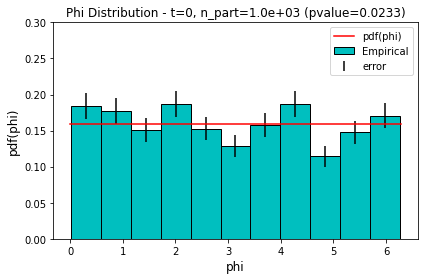

In [354]:
# Histogram Section #

# Generation of the normalized histogram and of the error bars
area = sum(np.diff(edges)*counts)
error = np.sqrt(counts) # Poissonian errors
bincenters = 0.5*(edges[1:]+edges[:-1])

normalized_counts_p, Bin_edges_p, hist_p = plt.hist(phi,bins='auto',range=None,density=True,color='c',edgecolor='black',label='Empirical')
error = error/area # the error bar must be rescaled since we normalized the histogram 
plt.errorbar(bincenters,normalized_counts_p,yerr=error,fmt='none',label='error',color='k')

## generation of the arrays containing some pdf's points
phi_pdf = np.empty(10)
ascissa = np.linspace(0,2*math.pi,10)
phi_pdf = np.ones(10)*pdf_p()        
        
plt.plot(ascissa,phi_pdf,color='r',label='pdf(phi)')
plt.ylim(0,0.3)
plt.xlabel('phi',fontsize=12)
plt.ylabel('pdf(phi)',fontsize=12)
plt.title('Phi Distribution - t=0, n_part={:3.1e} (pvalue={:3.3})'.format(Nparticles,pvalue))
plt.legend()
plt.tight_layout()
plt.savefig('Phi_histo_1000.jpg') 

In [355]:
## Theta Distribution

In [356]:
## pdf and cdf of the phi angle
def pdf_t(t):
    return 0.5*np.sin(t)
def cdf_t(t):
    return 0.5*(1-np.cos(t))

In [357]:
# Chisquare Section #
empirical,edges = np.histogram(theta,bins='auto')
counts = np.copy(empirical) # used in the Histogram Section
theorical = []
for i_bin in range(len(empirical)):
    if empirical[i_bin]>9:
        prob = cdf_t(edges[i_bin+1]) - cdf_t(edges[i_bin])
        theorical.append(prob*Nparticles)        
empirical = empirical[empirical>9] 

sta, pvalue = chisquare(empirical,theorical)
if pvalue>=0.05: print('pvalue: {}, test superato'.format(pvalue))
else: print('pvalue: {}, test non superato'.format(pvalue))

pvalue: 0.54800645766768, test superato


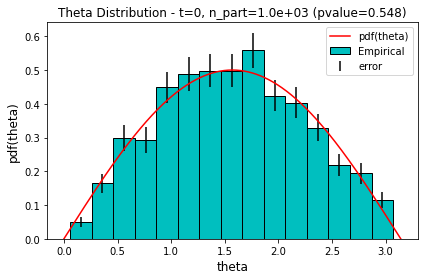

In [358]:
# Histogram Section #

# Generation of the normalized histogram and of the error bars
area = sum(np.diff(edges)*counts)
error = np.sqrt(counts) # Poissonian errors
bincenters = 0.5*(edges[1:]+edges[:-1])

normalized_counts_t, Bin_edges_t, hist_t = plt.hist(theta,bins='auto',range=None,density=True,color='c',edgecolor='black',label='Empirical')
error = error/area # the error bar must be rescaled since we normalized the histogram 
plt.errorbar(bincenters,normalized_counts_t,yerr=error,fmt='none',label='error',color='k')

## generation of the arrays containing some pdf's points
theta_pdf = np.empty(1000)
ascissa = np.linspace(0,math.pi,1000)
theta_pdf = pdf_t(ascissa)        
    
plt.plot(ascissa,theta_pdf,color='r',label='pdf(theta)')
plt.xlabel('theta',fontsize=12)
plt.ylabel('pdf(theta)',fontsize=12)
plt.title('Theta Distribution - t=0, n_part={:3.1e} (pvalue={:3.3})'.format(Nparticles,pvalue))
plt.legend()
plt.tight_layout()
plt.savefig('Theta_histo_1000.jpg') 

In [359]:
## Density Distribution

In [360]:
# density function
def rho(r,b,M):
    return M/(4/3*math.pi*b**3)/(1+(r/b)**2)**(5/2)

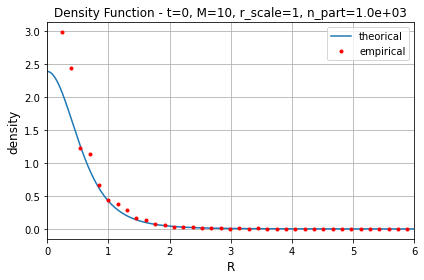

In [361]:
## generation of the theorical density
density = np.empty(1000)
ascissa = np.linspace(0,10,1000)
density = rho(ascissa,r_scale,M)  
plt.plot(ascissa,density,label='theorical')

## computation of the empirical density
counts, bin_edges = np.histogram(radius, bins=200) # if you are not satisfied, choose 'bins' manually
system_density = []
for i in range(len(counts)):
    system_density.append(counts[i]*m/(4/3*math.pi*(bin_edges[i+1]**3-bin_edges[i]**3)))

plt.plot(bin_edges[1::],system_density,'r.',label='empirical')
left_range = 0
right_range = 6
plt.xlim(left_range,right_range)
plt.xlabel('R',fontsize=12)
plt.ylabel('density',fontsize=12)
plt.title('Density Function - t=0, M={}, r_scale={}, n_part={:3.1e}'.format(M,r_scale,Nparticles))
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig('density_function_1000.jpg') 
## N.B. in order to compute the error associated to the empirical density, one should use the error propagation
## In this case we decided to evaluate the accuracy qualitatively

In [362]:
## q Distribution

In [363]:
Norm = 23.285605868167888 # normalization constant of the distribution function computed numerically (you can find the
                           # code at the end of this notebook)
def pdf_q(q,Norm): 
    return Norm*(1-q**2)**(7/2)*q**2
q_max = (2)**(1/2)/3  # abscissa where the distribution 'dist_func' has a maximum
f_max = pdf_q(q_max,Norm)

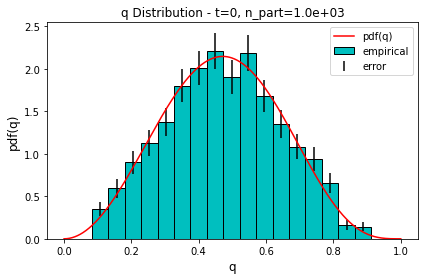

In [364]:
# Histogram Section #

counts, edges = np.histogram(q,bins='auto')
area = sum(np.diff(edges)*counts)
error = np.sqrt(counts) # Poissonian errors
bincenters = 0.5*(edges[1:]+edges[:-1])

normalized_counts_q, Bin_edges_q, hist_q = plt.hist(q,bins='auto',range=None,density=True,color='c',edgecolor='black',label='empirical')

error = error/area # the error bar must be rescaled since we normalized the histogram 
plt.errorbar(bincenters,normalized_counts_q,yerr=error,fmt='none',label='error',color='k')

## generation of the arrays containing some pdf's points
q_pdf = np.empty(1000)
ascissa = np.linspace(0,1,1000)
q_pdf = pdf_q(ascissa,Norm)        
        
plt.plot(ascissa,q_pdf,color='r',label='pdf(q)')
plt.xlabel('q',fontsize=12)
plt.ylabel('pdf(q)',fontsize=12)
plt.title('q Distribution - t=0, n_part={:3.1e}'.format(Nparticles))
plt.legend()
plt.tight_layout()
plt.savefig('q_histo_1000.jpg') 

In [365]:
###################################################################################################################

In [366]:
## Section 3 - Instruction to compile the code from the 'treecode' from the terminal and hints to set the parameters ##

In [367]:
# When you have runned 'Section 1', your system initial conditions will be saved in 'initial_conditions_file.txt';
# than, before running the 'Plummer's Sphere Stability - Analysis code', you need to run from 
# the terminal the c++ executable file. You can write (for example):
#
#   ./treecode in=initial_conditions_file.txt out=output_data.txt dtime=0.0005 eps=0.03 theta=0.1 options=out-phi tstop=0.5 dtout=0.05 > system_description.txt
#
# All the parameters are expressed in internal units; it's useful to compute the dynamical time of the system:

t_dynamical = r_scale/(M/r_scale)**(1/2)

# Here you can find the description of some of the parameters passed through the terminal (see for more details
# the documentation of the 'Barnes tree code' - http://www.ifa.hawaii.edu/faculty/barnes/treecode/treeguide.html):
# 
# - dtime: it is the integration time step. Set it not too big and too small; for example choose dtime=t_dynamical/(10^a)
#   It's convenient to use a timestep which has an exact representation as a floating-point number

dtime = t_dynamical/(10**2)

# - eps: it is the smoothing length used in the gravitational force calculation.
#  Choose a value that is a fraction of the typical separation between particles: 10^(-b)*(Vol/Nparticles)**(1/3)
#  Here we divided the sphere in shells, computed the particles' mean distance in each shell and selected the 
#  smallest one

counts, bin_edges = np.histogram(radius, bins='auto')
MeanSeparation = []
for i in range(len(counts)):
    if counts[i]!=0:
        MeanSeparation.append( ((4/3*math.pi*(bin_edges[i+1]**3-bin_edges[i]**3))/counts[i])**(1/3))
MinMeanSeparation = min(MeanSeparation)
eps = MinMeanSeparation/10

# - theta: it is the opening angle used to adjust the accuracy of the force calculation. 
#  Values less than unity produce more accurate forces, albeit at greater computational expense.

theta = 0.1

# - options=out-phi: it saves in the output_data.txt also the potential energy

# - tstop: it is the time at which the N-Body integration terminates. Set it, for example, as tstop=2*t_dynamical

tstop = 10*t_dynamical

# - dtout: it is the time interval between output files. To insure that outputs are performed when expected, dtout
# should be a multiple of dtime. The number of snapshots depends on 'dtout': the less its value is, the more number
# of outputs you'll have. A greater number of snapshots will be useful during the analysis because you'll have
# more information about the system but the computational cost of the analysis will be increased.

dtout = dtime*3

Nsnapshots = int(tstop/dtout)

In [368]:
print('\ndtime: ',dtime)
print('\nMean separation: ',MinMeanSeparation,'    eps: ',eps)
print('\ntheta: ', theta)
print('\ntstop: ', tstop)
print('\ndtout: ', dtout)
print('\nNsnaphots: ', Nsnapshots)


dtime:  0.0031622776601683794

Mean separation:  0.15321587953811203     eps:  0.015321587953811203

theta:  0.1

tstop:  3.1622776601683795

dtout:  0.009486832980505138

Nsnaphots:  333
